In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)

In [40]:
conn = sqlite3.connect("/Users/kyleshiroma/Desktop/Sensor_Project/telemetry.db")  
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Tables in the database:")
for table in tables:
    print(table[0])

Tables in the database:
telemetry
telemetry_final


In [42]:
cursor.execute("PRAGMA table_info(telemetry_final);")
print(cursor.fetchall())

[(0, 'time', 'TEXT', 0, None, 0), (1, 'value', 'REAL', 0, None, 0)]


In [44]:
cursor.execute("SELECT * FROM telemetry_final LIMIT 10;")
rows = cursor.fetchall()
for row in rows:
    print(row)

('2025-04-05T17:00:00.1Z', 13.6652)
('2025-04-05T17:00:00.3Z', 13.51391)
('2025-04-05T17:00:00.5Z', 13.34281)
('2025-04-05T17:00:00.7Z', 13.24304)
('2025-04-05T17:00:00.9Z', 13.11142)
('2025-04-05T17:00:01.1Z', 12.98077)
('2025-04-05T17:00:01.2Z', 12.90313)
('2025-04-05T17:00:01.6Z', 12.96106)
('2025-04-05T17:00:01.8Z', 13.0795)
('2025-04-05T17:00:02Z', 13.25339)


In [46]:
df = pd.read_sql_query("SELECT * FROM telemetry_final;", conn)
print(df.head())

                     time     value
0  2025-04-05T17:00:00.1Z  13.66520
1  2025-04-05T17:00:00.3Z  13.51391
2  2025-04-05T17:00:00.5Z  13.34281
3  2025-04-05T17:00:00.7Z  13.24304
4  2025-04-05T17:00:00.9Z  13.11142


In [48]:
df = df[df['time'].str.startswith("2025")]  

df['time'] = pd.to_datetime(df['time'], errors='coerce', format='ISO8601')

df.dropna(subset=['time'], inplace=True)

df.set_index('time', inplace=True)

In [49]:
df_resampled = df.resample('1S').mean()  
print(df_resampled.head())

                              value
time                               
2025-04-05 17:00:00+00:00  4.096661
2025-04-05 17:00:01+00:00  3.941414
2025-04-05 17:00:02+00:00  4.202960
2025-04-05 17:00:03+00:00  4.334416
2025-04-05 17:00:04+00:00  4.775669


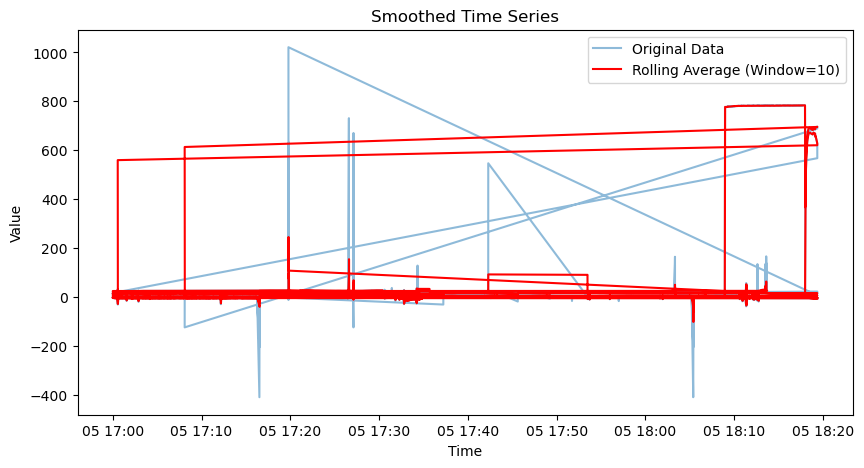

In [25]:
df['rolling_mean'] = df['value'].rolling(window=10).mean()

plt.figure(figsize=(10, 5))
plt.plot(df.index, df['value'], label='Original Data', alpha=0.5)
plt.plot(df.index, df['rolling_mean'], label='Rolling Average (Window=10)', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Smoothed Time Series')
plt.legend()
plt.show()

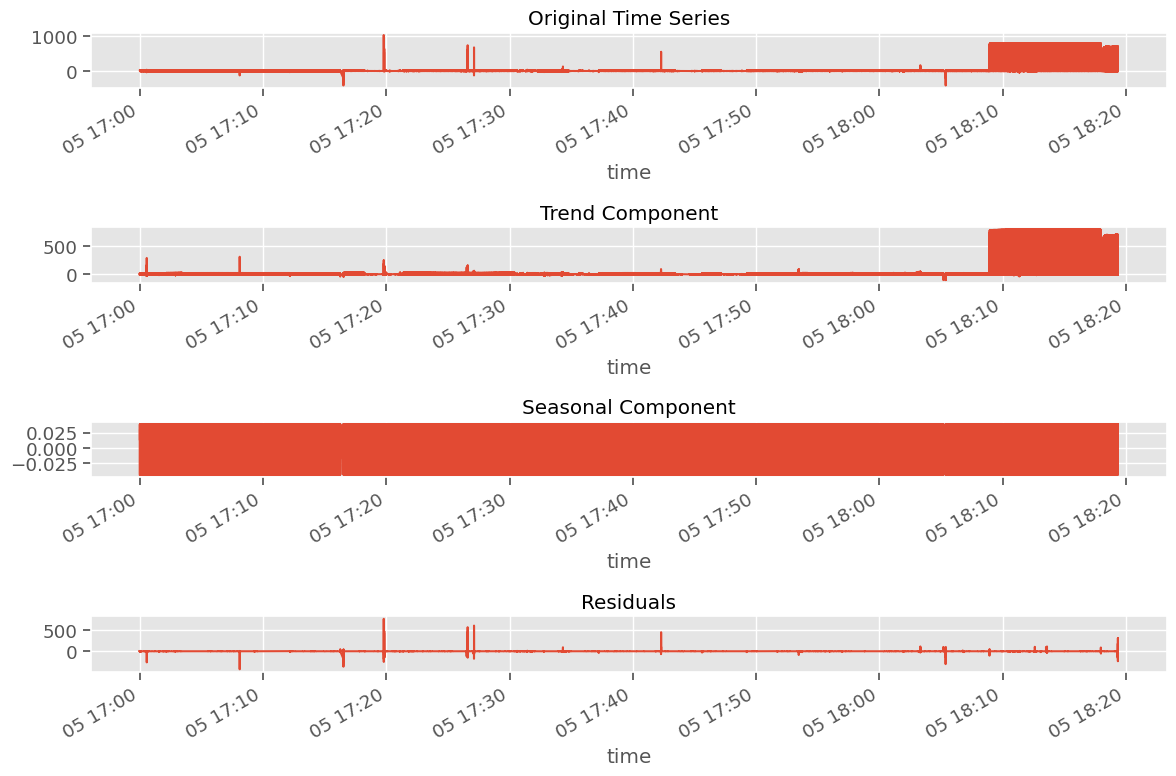

In [ ]:
result = seasonal_decompose(df['value'], model='additive', period=10)  

fig, axes = plt.subplots(4, 1, figsize=(12, 8))
result.observed.plot(ax=axes[0], title='Original Time Series')
result.trend.plot(ax=axes[1], title='Trend Component')
result.seasonal.plot(ax=axes[2], title='Seasonal Component')
result.resid.plot(ax=axes[3], title='Residuals')
plt.tight_layout()
plt.show()

adf_test = adfuller(df['value'])
print(f"ADF Test Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] > 0.05:
    df['diff_value'] = df['value'].diff().dropna()
    plt.figure(figsize=(10,5))
    plt.plot(df['diff_value'], label="Differenced Time Series")
    plt.legend()
    plt.title("Differenced Time Series for Stationarity")
    plt.show()